In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
from scipy.stats import norm
from gp_dev.core import *
from ddop.datasets import load_yaz
from pathlib import Path
import datetime
import category_encoders as ce
import pandas as pd

from ddop.newsvendor import RandomForestWeightedNewsvendor
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

In [3]:
path = Path("..")
path_ds = path/'datasets'
path_res = path/'res_data'
path_plot = path/'plots'

split_date = pd.to_datetime('2018-04-30')

In [4]:
df = pd.read_csv(path_ds/'dataforprediction_V2.csv')
targets = [101,109,110]
df = df[df.artNr.isin(targets)]
fils = [19,24,27,33,34]
df = df[df.FilNr.isin(fils)]

cat_var = ['dayofWeek', 'month', 'State']
num_var = ['RSK', 'TMK', 'TXK', 'TNK']
bin_var = ['currentWeek_Keine Anzeige',
           'currentWeek_3+1Aktion', 'currentWeek_2+1Aktion', 
           'currentWeek_info', 'lastWeek_Keine Anzeige',
           'lastWeek_3+1Aktion', 'lastWeek_2+1Aktion', 'lastWeek_info', 'schoolholidays', 'isHolyday', 'isHolydayNext2Days']
df = df.drop(columns = df.columns.difference(cat_var+bin_var+num_var+['daySalesUnit', 'shortDate', 'artNr', 'FilNr']))

df[bin_var] = df[bin_var].astype('int')

df.rename(columns={'shortDate': 'DEMAND_DATE'}, inplace=True)
df['DEMAND_DATE'] = pd.to_datetime(df['DEMAND_DATE'])

df.set_index('DEMAND_DATE', inplace = True)
df['DEMAND_DATE'] = df.index
df['DEMAND_DATE'] = (df['DEMAND_DATE'] - datetime.datetime(1970,1,1)).astype('timedelta64[D]').values

selected_columns = df.columns.difference(['daySalesUnit']).tolist() + ['daySalesUnit']
df_raw = df[selected_columns].copy()

# Single GP

In [31]:
#res = []
#for method in ['saa', 'timeseries', 'one-hot encoding', 'target encoding']:
for method in ['target encoding']:
    for fil in fils:
        for target in [101,109,110]:

            if method == 'timeseries':
                df = df_raw.loc[(df_raw.artNr==target) & (df_raw.FilNr == fil),['DEMAND_DATE', 'daySalesUnit']]

            else:
                df = df_raw[(df_raw.artNr==target) & (df_raw.FilNr == fil)].copy()
                df = df.drop(columns = ['DEMAND_DATE', 'artNr'])

            # make train/val/test
            train_x_df, train_y_df = df.loc[df.index<pd.to_datetime('2018-04-30'), df.columns.difference(['daySalesUnit'])], df.loc[df.index<pd.to_datetime('2018-04-30'), 'daySalesUnit']
            test_x_df, test_y_df = df.loc[~(df.index<pd.to_datetime('2018-04-30')), df.columns.difference(['daySalesUnit'])], df.loc[~(df.index<pd.to_datetime('2018-04-30')), 'daySalesUnit']

            train_y = train_y_df.values
            test_y = test_y_df.values

            # target encoding
            if method == 'target encoding':
                for cat in cat_var:
                    encoder = ce.TargetEncoder()
                    train_x_df[cat] = encoder.fit_transform(train_x_df[cat].astype('category'), train_y_df)
                    test_x_df[cat] = encoder.transform(test_x_df[cat].astype('category'))

            elif method == 'one-hot encoding':
                for cat in cat_var:
                    encoder = ce.OneHotEncoder()
                    train_x_df = pd.concat([train_x_df, encoder.fit_transform(train_x_df[cat].astype('category'), train_y_df)], axis=1).drop(columns = cat)
                    test_x_df = pd.concat([test_x_df, encoder.transform(test_x_df[cat].astype('category'))], axis=1).drop(columns = cat)

            if method != 'saa':
                scaler = MinMaxScaler()
                scaler.fit(train_x_df)

                train_x = scaler.transform(train_x_df)
                test_x = scaler.transform(test_x_df)

                # Kernel with parameters given in GPML book
                k1 = 1**2 * RBF(length_scale=0.261)  # long term smooth rising trend
                k2 = 2.4**2 * RBF(length_scale=90.0) \
                    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
                k3 = 0.66**2 \
                    * RationalQuadratic(length_scale=1.2, alpha=0.78) # medium term irregularity
                k4 = 0.18**2 * RBF(length_scale=0.134) \
                    + WhiteKernel(noise_level=1.09**2)  # noise terms

                if method == 'timeseries':
                    kernel_gpml = k1 + k2 + k3 + k4

                else:
                    kernel_gpml = k1 + k4
                    kernel_gpml = 316**2 * RBF(length_scale=39) + 0.475**2 * RBF(length_scale=0.802) + WhiteKernel(noise_level=0.224)

                gp = GaussianProcessRegressor(kernel=kernel_gpml, normalize_y=True)#, alpha=1)
                gp.fit(train_x, train_y)

                print("\nLearned kernel: %s" % gp.kernel_)
                print("Log-marginal-likelihood: %.3f"
                      % gp.log_marginal_likelihood(gp.kernel_.theta))

                nv_means, y_std = gp.predict(test_x,  return_std=True)
                nv_sigma = y_std

            for c in range(5,100, 5):
                cu = c/100
                co = 1-cu

                if method == 'saa':
                    nv_quantile = np.quantile(train_y, q=cu/(cu+co))
                    cost= np.mean([nv_cost(nv_quantile, y, cu, co) for y in test_y])
                else:
                    nv_solution = nv_means+norm.ppf(cu/(cu+co))*nv_sigma
                    cost =  np.mean([nv_cost(q, y, cu, co) for q, y in zip(nv_solution, test_y)])

                ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost, "type":method, "target": target, "Filiale": fil})
                res.append(ser_tmp)
                
#df_res = pd.DataFrame(res)

/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 2.66**2 * RBF(length_scale=2.96) + 0.697**2 * RBF(length_scale=0.564) + WhiteKernel(noise_level=0.374)
Log-marginal-likelihood: -882.696


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.772**2 * RBF(length_scale=0.982) + 1.47**2 * RBF(length_scale=1.83) + WhiteKernel(noise_level=0.435)
Log-marginal-likelihood: -918.523


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 2.5**2 * RBF(length_scale=2.15) + 0.389**2 * RBF(length_scale=0.325) + WhiteKernel(noise_level=0.455)
Log-marginal-likelihood: -973.795


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.319**2 * RBF(length_scale=0.108) + 1.96**2 * RBF(length_scale=1.28) + WhiteKernel(noise_level=0.136)
Log-marginal-likelihood: -623.722


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.54**2 * RBF(length_scale=1.26) + 0.437**2 * RBF(length_scale=0.543) + WhiteKernel(noise_level=0.161)
Log-marginal-likelihood: -573.605


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 2.03**2 * RBF(length_scale=1.25) + 0.366**2 * RBF(length_scale=0.253) + WhiteKernel(noise_level=0.396)
Log-marginal-likelihood: -952.145


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.342**2 * RBF(length_scale=0.495) + 1.67**2 * RBF(length_scale=1.41) + WhiteKernel(noise_level=0.173)
Log-marginal-likelihood: -569.796


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.54**2 * RBF(length_scale=1.14) + 0.44**2 * RBF(length_scale=0.332) + WhiteKernel(noise_level=0.155)
Log-marginal-likelihood: -603.454


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.77**2 * RBF(length_scale=1.68) + 0.646**2 * RBF(length_scale=0.294) + WhiteKernel(noise_level=0.279)
Log-marginal-likelihood: -835.892


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.54**2 * RBF(length_scale=1.24) + 0.314**2 * RBF(length_scale=0.179) + WhiteKernel(noise_level=0.146)
Log-marginal-likelihood: -578.395


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.43**2 * RBF(length_scale=1.43) + 0.315**2 * RBF(length_scale=0.444) + WhiteKernel(noise_level=0.102)
Log-marginal-likelihood: -382.676


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.00316**2 * RBF(length_scale=418) + 1.6**2 * RBF(length_scale=1.6) + WhiteKernel(noise_level=0.281)
Log-marginal-likelihood: -733.586


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.693**2 * RBF(length_scale=1.33) + 1.4**2 * RBF(length_scale=1.33) + WhiteKernel(noise_level=0.23)
Log-marginal-likelihood: -663.697


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 0.00316**2 * RBF(length_scale=20.8) + 1.48**2 * RBF(length_scale=1.18) + WhiteKernel(noise_level=0.179)
Log-marginal-likelihood: -582.792


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.86**2 * RBF(length_scale=1.66) + 0.29**2 * RBF(length_scale=0.272) + WhiteKernel(noise_level=0.409)
Log-marginal-likelihood: -922.061


# Combined GP

In [11]:
test_x_df, test_y_df = test_df[test_df.columns.difference(['daySalesUnit'])], test_df['daySalesUnit']

In [30]:
#gp_all = gp

In [28]:
res = []
#for method in ['target encoding', 'one-hot encoding', 'timeseries']:
for method in ['target encoding']: 

    if method == 'timeseries':
        df = df_raw['FilNr', 'artNr', 'DEMAND_DATE', 'daySalesUnit'].copy()

    else:
        df = df_raw.copy()
        df = df.drop(columns = ['DEMAND_DATE'])

    # make train/val/test
    train_df = df[df.index<split_date].set_index(['FilNr', 'artNr'], drop=False).copy()
    train_df.rename(columns={'FilNr': 'Filiale', 'artNr': 'Artikel' }, inplace=True)
    test_df = df[~(df.index<split_date)].set_index(['FilNr', 'artNr'], drop=False).copy()
    test_df.rename(columns={'FilNr': 'Filiale', 'artNr': 'Artikel' }, inplace=True)

    y_means = train_df.groupby(['FilNr', 'artNr'])['daySalesUnit'].mean()
    y_std = train_df.groupby(['FilNr', 'artNr'])['daySalesUnit'].std()

    train_df['y_scaled'] =  train_df.groupby(['FilNr', 'artNr'])['daySalesUnit'].transform(lambda y: ((y-y_means[y.index[0]])/y_std[y.index[0]]))
    #test_df['y_scaled'] =  test_df.groupby(['FilNr', 'artNr'])['daySalesUnit'].transform(lambda y: ((y-y_means[y.index[0]])/y_std[y.index[0]]))
    
    train_x_df, train_y_df = train_df[train_df.columns.difference(['daySalesUnit', 'y_scaled'])], train_df[['daySalesUnit', 'y_scaled']]
    test_x_df, test_y_df = test_df[test_df.columns.difference(['daySalesUnit'])], test_df[['daySalesUnit']]
    
    train_y = train_y_df['y_scaled'].values

    # target encoding
    if method == 'target encoding':
        print(method)
        for cat in cat_var:
            encoder = ce.TargetEncoder()
            train_x_df.loc[:, cat] = encoder.fit_transform(train_x_df[cat].astype('category'), train_y)
            test_x_df.loc[:, cat] = encoder.transform(test_x_df[cat].astype('category'))

    elif method == 'one-hot encoding':
        print(method)
        for cat in cat_var:
            encoder = ce.OneHotEncoder()
            train_x_df = pd.concat([train_x_df, encoder.fit_transform(train_x_df[cat].astype('category'), train_y)], axis=1).drop(columns = cat)
            test_x_df = pd.concat([test_x_df, encoder.transform(test_x_df[cat].astype('category'))], axis=1).drop(columns = cat)

    train_x = train_x_df.values
    test_x = test_x_df.values
    
        
    #scaler = MinMaxScaler()
    #scaler.fit(train_x_df)

    #train_x = scaler.transform(train_x_df)
    #test_x = scaler.transform(test_x_df)

    # Kernel with parameters given in GPML book
    k1 = 1**2 * RBF(length_scale=0.261)  # long term smooth rising trend
    k2 = 2.4**2 * RBF(length_scale=90.0) \
        * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
    k3 = 0.66**2 \
        * RationalQuadratic(length_scale=1.2, alpha=0.78) # medium term irregularity
    k4 = 0.18**2 * RBF(length_scale=0.134) \
        + WhiteKernel(noise_level=1.09**2)  # noise terms

    if method == 'timeseries':
        kernel_gpml = k1 + k2 + k3 + k4
    else:
        kernel_gpml = k1 + k4

    #gp = GaussianProcessRegressor(kernel=kernel_gpml, normalize_y=True)#, alpha=1)
    print('fitting')
   # gp.fit(train_x, train_y)

    print("\nLearned kernel: %s" % gp.kernel_)
    print("Log-marginal-likelihood: %.3f"
          % gp.log_marginal_likelihood(gp.kernel_.theta))

    #nv_means_scaled, nv_sigma_scaled = gp.predict(test_x,  return_std=True)
    test_y_df['nv_means_scaled'] = nv_means_scaled
    test_y_df['nv_sigma_scaled'] = nv_sigma_scaled
    test_y_df['nv_means'] = test_y_df.groupby(['FilNr', 'artNr'])['nv_means_scaled'].transform(lambda y: ((y*y_std[y.index[0]])+ y_means[y.index[0]]))
    test_y_df['nv_sigma'] = test_y_df.groupby(['FilNr', 'artNr'])['nv_sigma_scaled'].transform(lambda y: ((y*y_std[y.index[0]])+ y_means[y.index[0]]))
    
    for target in targets:
            for fil in fils:
                for c in range(5,100, 5):
                    cu = c/100
                    co = 1-cu

                    nv_solution =  test_y_df.loc[(fil, target), 'nv_means'].values+norm.ppf(cu/(cu+co))*test_y_df.loc[(fil, target), 'nv_sigma'].values
                    cost =  np.mean([nv_cost(max(q,0), y, cu, co) for q, y in zip(nv_solution, test_y_df.loc[(fil, target), 'daySalesUnit'].values)])

                    ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost, "type":method, "target": target, "Filiale": fil})
                    res.append(ser_tmp)

df_res = pd.DataFrame(res)

target encoding


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/pandas/core/indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/pandas/core/indexing.py:1717: SettingWithCopyWarning

fitting

Learned kernel: 316**2 * RBF(length_scale=39) + 0.475**2 * RBF(length_scale=0.802) + WhiteKernel(noise_level=0.224)
Log-marginal-likelihood: -13737.000


<ipython-input-28-650526950a77>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_y_df['nv_means_scaled'] = nv_means_scaled
<ipython-input-28-650526950a77>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_y_df['nv_sigma_scaled'] = nv_sigma_scaled
<ipython-input-28-650526950a77>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='FilNr,artNr'>

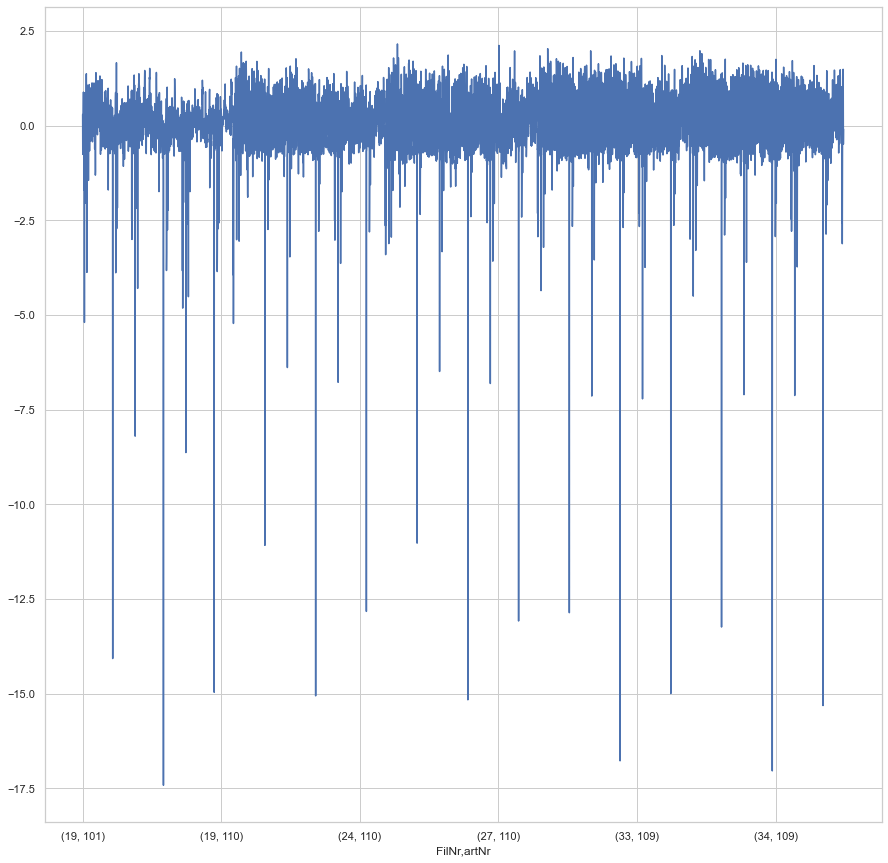

In [27]:
test_y_df['nv_means_scaled'].plot()

/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='FilNr,artNr'>

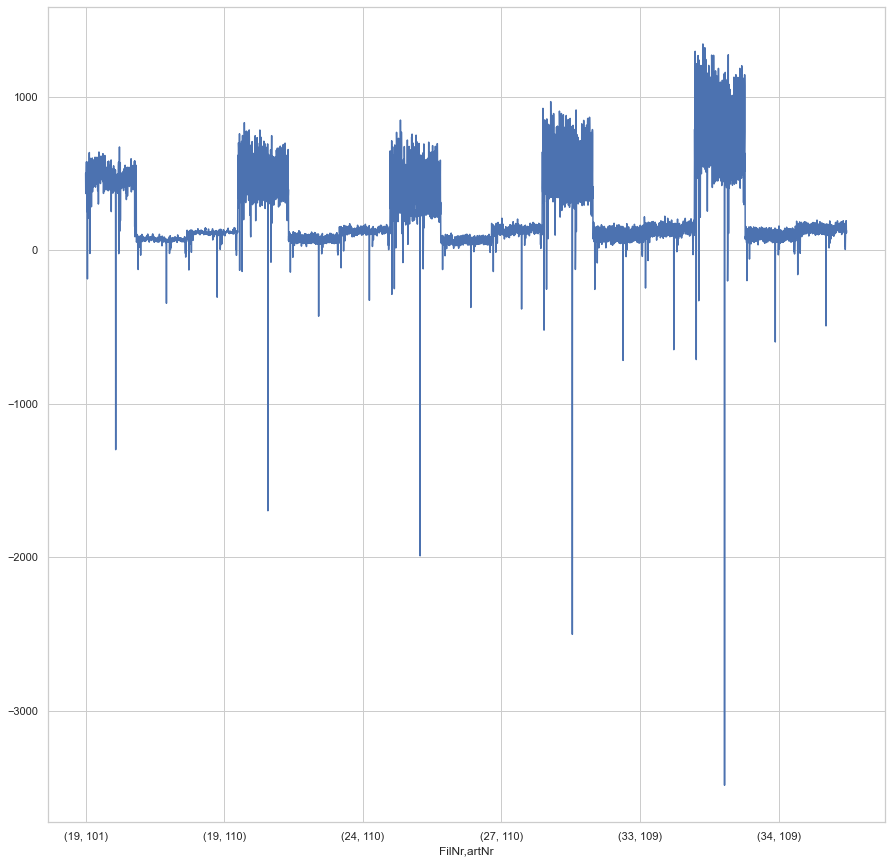

In [26]:
test_y_df['nv_means'].plot()

nnn= 'SOF_results_Symmetric.csv'
df_tmp = pd.read_csv(nnn)
#df_tmp = df_tmp.drop(columns=["Unnamed: 0"])
df_tmp['target']="STEAK"
df_tmp.to_csv(nnn, index=False)

# RandomForest 

In [11]:
df = pd.read_csv(path_ds/'dataforprediction_V2.csv')
targets = [101,109,110]
df = df[df.artNr.isin(targets)]
fils = [19,24,27,33,34]
df = df[df.FilNr.isin(fils)]

cat_var = ['dayofWeek', 'month', 'State', 'artNr', 'FilNr']
num_var = ['RSK', 'TMK', 'TXK', 'TNK']
bin_var = ['currentWeek_Keine Anzeige',
           'currentWeek_3+1Aktion', 'currentWeek_2+1Aktion', 
           'currentWeek_info', 'lastWeek_Keine Anzeige',
           'lastWeek_3+1Aktion', 'lastWeek_2+1Aktion', 'lastWeek_info', 'schoolholidays', 'isHolyday', 'isHolydayNext2Days']

df = df.drop(columns = df.columns.difference(cat_var+bin_var+num_var+['daySalesUnit', 'shortDate']))

df[bin_var] = df[bin_var].astype('int')

df.rename(columns={'shortDate': 'DEMAND_DATE'}, inplace=True)
df['DEMAND_DATE'] = pd.to_datetime(df['DEMAND_DATE'])

df.set_index('DEMAND_DATE', inplace = True, drop=False)
df['DEMAND_DATE'] = (df['DEMAND_DATE'] - datetime.datetime(1970,1,1)).astype('timedelta64[D]').values

selected_columns = df.columns.difference(['daySalesUnit']).tolist() + ['daySalesUnit']
df_raw = df[selected_columns].copy()

In [53]:
print('Test:', test_y_df.index.min(), 'bis ', test_y_df.index.max(), ' - Beobachtungen: ', len(test_y_df))
print('Train:', train_y_df.index.min(), 'bis ', train_y_df.index.max(), ' - Beobachtungen: ', len(train_y_df))

Test: 2018-04-30 00:00:00 bis  2019-04-30 00:00:00  - Beobachtungen:  366
Train: 2016-01-02 00:00:00 bis  2018-04-29 00:00:00  - Beobachtungen:  849


In [ ]:
res = []
for method in ['target encoding', 'one-hot encoding']:

    df = df_raw.copy()
    df = df.drop(columns = ['DEMAND_DATE'])

    # make train/val/test
    train_x_df, train_y_df = df.loc[df.index<pd.to_datetime('2018-04-30'), df.columns.difference(['daySalesUnit'])], df.loc[df.index<pd.to_datetime('2018-04-30'), ['artNr', 'FilNr', 'daySalesUnit']]
    test_x_df, test_y_df = df.loc[~(df.index<pd.to_datetime('2018-04-30')), df.columns.difference(['daySalesUnit'])], df.loc[~(df.index<pd.to_datetime('2018-04-30')), ['artNr', 'FilNr', 'daySalesUnit']]
    
    train_x_df.set_index(['artNr', 'FilNr'], inplace = True, drop=False)
    train_x_df.sort_index(inplace = True)
    train_y_df.set_index(['artNr', 'FilNr'], inplace = True, drop=False)
    train_y_df.sort_index(inplace = True)
    test_x_df.set_index(['artNr', 'FilNr'], inplace = True, drop=False)
    test_x_df.sort_index(inplace = True)
    test_y_df.set_index(['artNr', 'FilNr'], inplace = True, drop=False)
    test_y_df.sort_index(inplace = True)
    
    # target encoding
    if method == 'target encoding':        
        for cat in cat_var:
            encoder = ce.TargetEncoder()
            train_x_df[cat] = encoder.fit_transform(train_x_df[cat].astype('category'), train_y_df.iloc[:,-1])
            test_x_df[cat] = encoder.transform(test_x_df[cat].astype('category'))

    elif method == 'one-hot encoding':
        for cat in cat_var:
            encoder = ce.OneHotEncoder()
            train_x_df = pd.concat([train_x_df, encoder.fit_transform(train_x_df[cat].astype('category'), train_y_df.iloc[:,-1])], axis=1).drop(columns = cat)
            test_x_df = pd.concat([test_x_df, encoder.transform(test_x_df[cat].astype('category'))], axis=1).drop(columns = cat)
            
    scaler = MinMaxScaler()
    train_x =scaler.fit_transform(train_x_df)
    train_y = train_y_df.loc[:,'daySalesUnit'].values
    
    for c in range(5,100, 5):
        cu = c/100
        co = 1-cu
        
        mdl_rf = RandomForestWeightedNewsvendor(cu=cu, co=co, verbose=0)
        mdl_rf.fit(train_x, train_y)
        
        for target in targets:
            for fil in fils:

                test_x = scaler.transform(test_x_df.loc[(target, fil)])
                test_y = test_y_df.loc[(target, fil),'daySalesUnit'].values

                cost =  np.abs(mdl_rf.score(test_x, test_y))[0]

                ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost, "type":'wsaa_'+ method, "target": target, "Filiale": fil})
                res.append(ser_tmp)

df_res = pd.DataFrame(res)

/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/hom

In [33]:
df_res.to_csv(path_res/'baeckerei.csv')

In [35]:
df_res = pd.read_csv(path_res/'baeckerei.csv')

In [22]:
df_res['cost'] = df_res['cost'].apply(lambda x: x[0] if type(x)==np.ndarray else x )

In [39]:
[570/2

SyntaxError: unexpected EOF while parsing (<ipython-input-39-b3c6ad0edaa1>, line 1)

In [40]:
df_res = pd.DataFrame(res[285:])

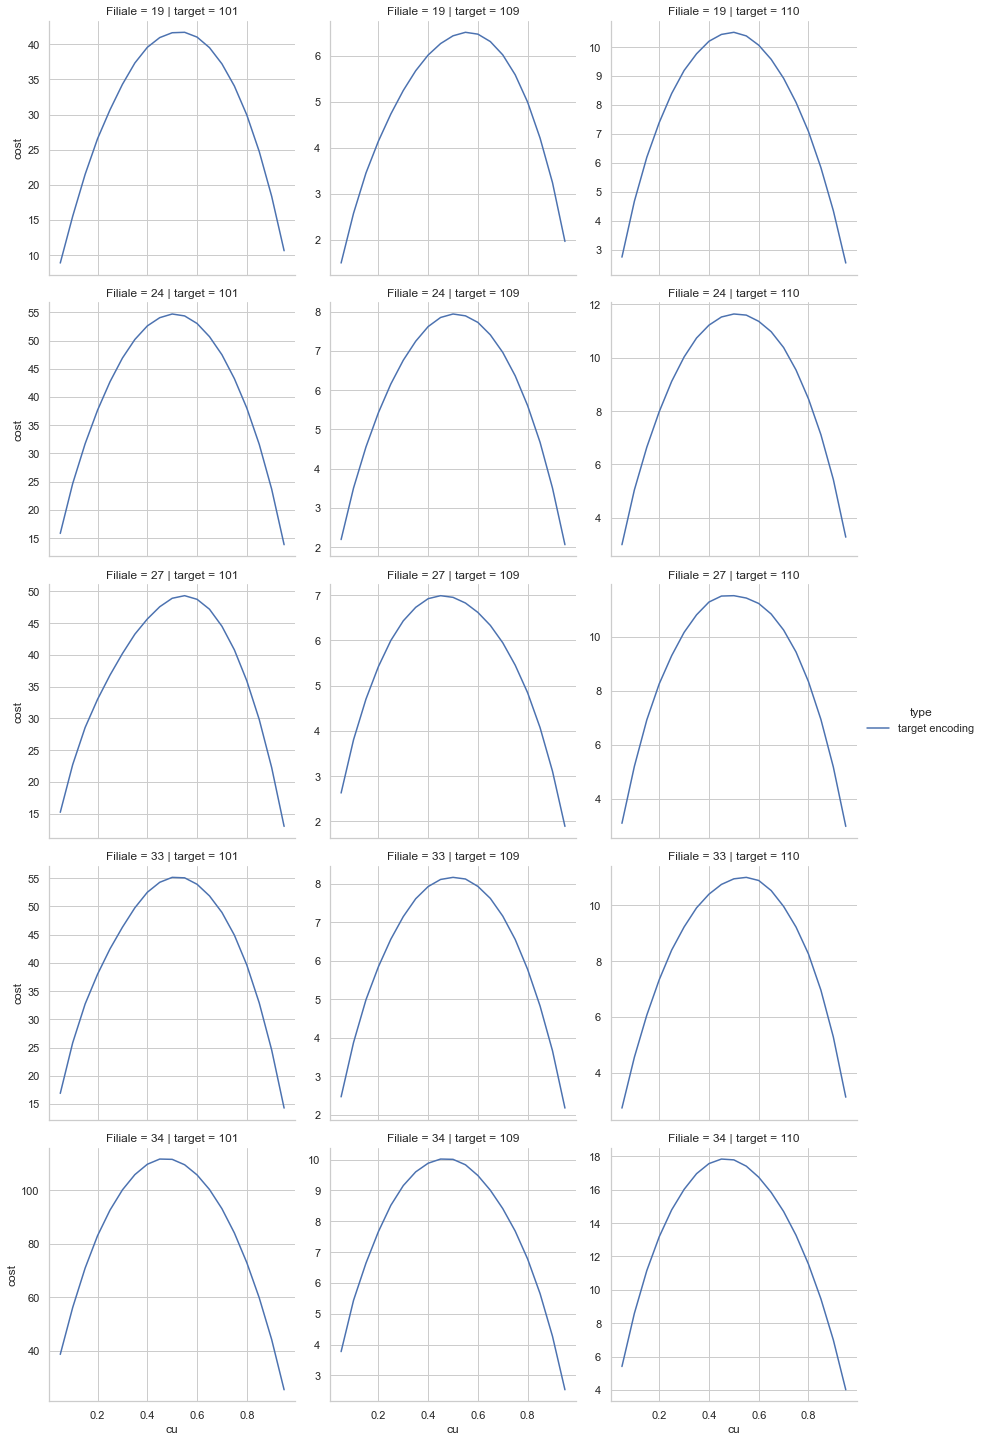

In [41]:
df_plot = df_res
#df_plot = pd.read_csv('res_data/gp_all-paste.csv')
#df_plot = df_plot[~(df_plot.type.isin(["timeseries"]))]
#df_plot = df_plot[~(df_plot.type.isin(["rf_approx_risk", "rf_approx_sol", "oracle"]))]
#df_plot = df_plot[~(df_plot.type.isin(["saa", "rf"]))]
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style('whitegrid')
sns.relplot(data=df_plot, x="cu", y="cost",facet_kws={'sharey':False}, row='Filiale',
    col="target", hue="type",kind="line", aspect=1, height=4); 

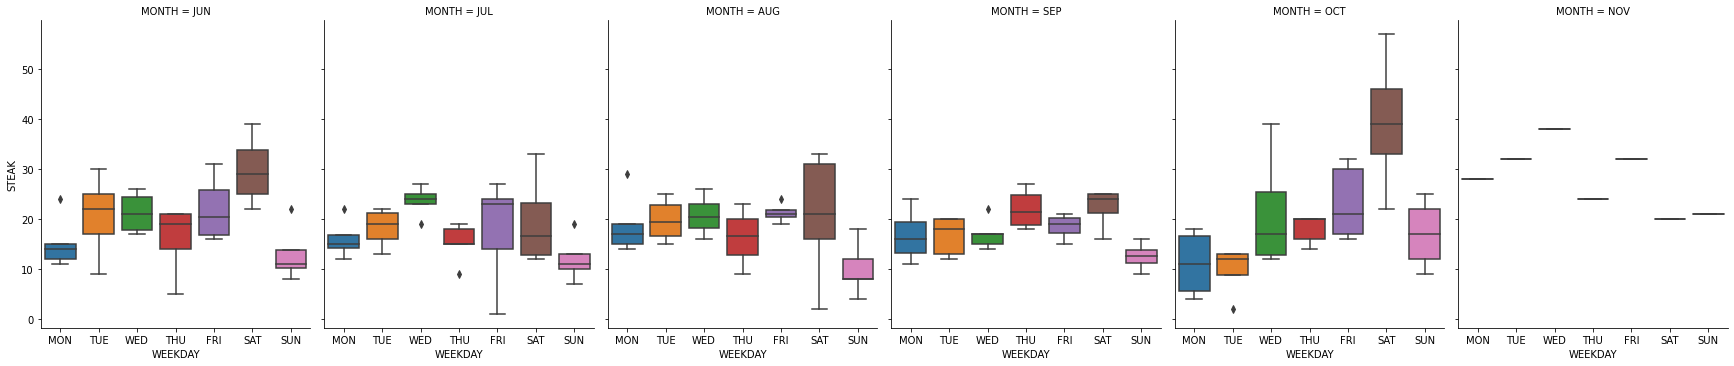

In [8]:
test_df = load_yaz(encode_date_features=False, include_prod=[target]).frame.iloc[n_train:,:].copy()
test_df['mean_pred'] =nv_means
test_df['std'] = nv_sigma


g = sns.catplot(x="WEEKDAY", y="STEAK",
                col="MONTH",# hue="MONTH",
                aspect=.8,
                data=test_df, kind="box");

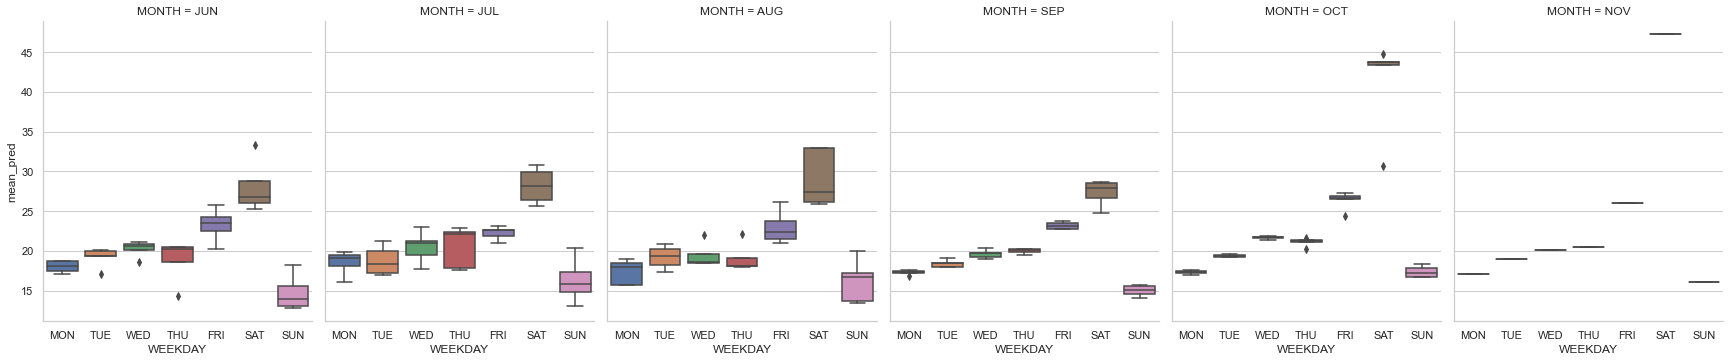

In [87]:
g = sns.catplot(x="WEEKDAY", y="mean_pred",
                col="MONTH",# hue="MONTH",
                aspect=.8,
                data=test_df, kind="box");

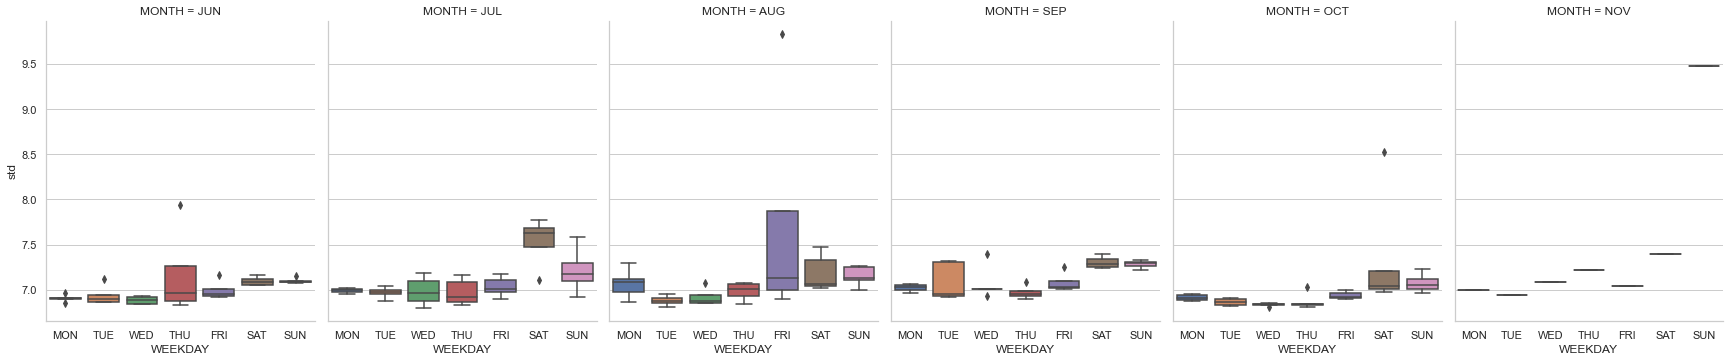

In [88]:
g = sns.catplot(x="WEEKDAY", y="std",
                col="MONTH",# hue="MONTH",
                aspect=.8,
                data=test_df, kind="box");

## Plot Space

In [46]:
f0 = [torch.linspace(0, 1, 200) for i in range(1)]
fx = torch.linspace(1,1, 200) #temp
fn = [torch.linspace(0, 1, 200) for i in range(5)]#[torch.linspace(0.5, 0.5, 200) for i in range(2)]


In [47]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    sample_x = torch.stack([*f0,fx,*fn] , axis=-1).cuda()
    observed_pred = likelihood(model(sample_x))

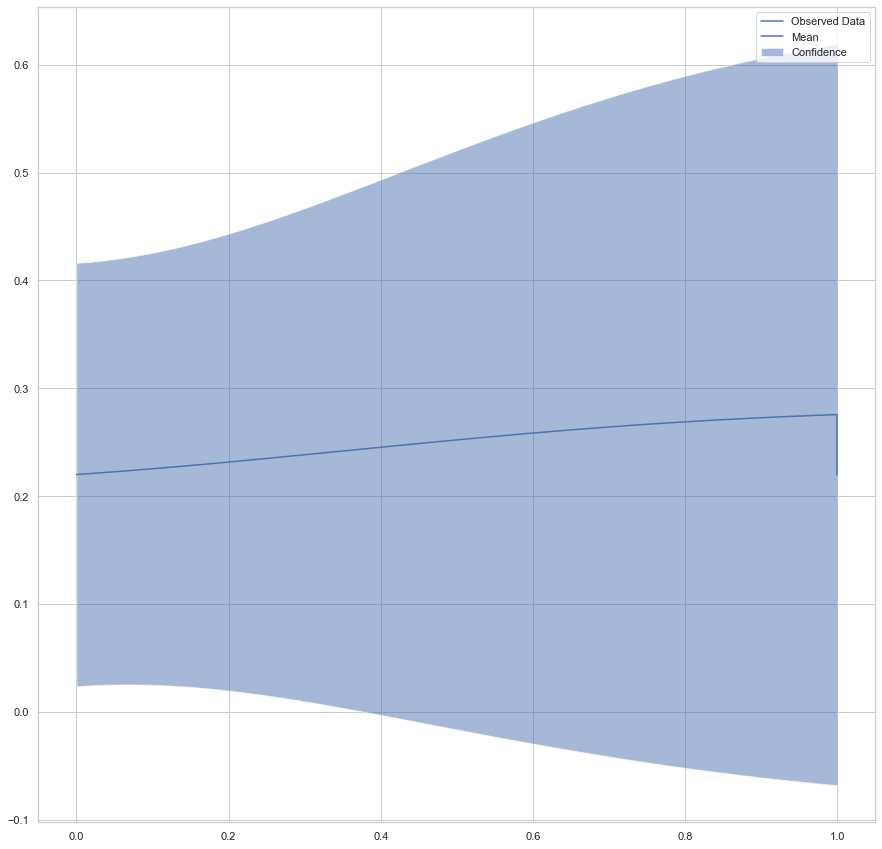

In [48]:
feature_idx=2
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(15, 15))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    #ax.plot(train_x[:,feature_idx].cpu().numpy(), train_y.cpu().numpy(), 'k*')
    #ax.plot(sample_x[:,feature_idx].cpu().numpy(), y_samples.cpu().numpy(), lw=1)
    # Plot predictive means as blue line
    ax.plot(fx.numpy(), observed_pred.mean.cpu().numpy(), 'b')
    ax.plot(sample_x[:,feature_idx].cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(sample_x[:,feature_idx].cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    #ax.fill_between(sample_x[:,feature_idx].cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])